In [190]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L2
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [195]:
train_folder = '../data/train'
test_folder = '../data/test'

x_img_size = 32

y_img_size = 256
y_img_channels = 3

In [196]:
def image_file_iterator(root):
    for subdir, dirs, files in os.walk(root):
        for file in files:
            if (file.endswith('.png')):
                yield os.path.join(subdir, file)

        for dir in dirs:
            for file in image_file_iterator(dir):
                yield os.path.join(subdir, file)

def scale_and_normalize(img, size):
    if (img.shape[0] != size or img.shape[1] != size):
        img = cv2.resize(img, (size, size))
    return img / 255

def datagen(data_root, batch_size):
    file_provider = image_file_iterator(data_root)
    files_pending = True
    while(files_pending):
        x_batch = []
        y_batch = []

        for ii in range(batch_size):
            fpath = next(file_provider, '') 

            if (fpath != ''):
                # Load source image
                src_img = cv2.imread(fpath)
                src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
                
                # Normalization
                #src_img = src_img / 255

                # Make X
                x_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
                x_img = scale_and_normalize(x_img, x_img_size)
                x_batch.append(x_img)

                # Make Y
                y_img = scale_and_normalize(src_img, y_img_size)
                y_batch.append(y_img)

            else:
                files_pending = False
                break
        
        if len(x_batch) > 0:
            yield np.array(x_batch), np.array(y_batch)

In [197]:
# Let's see the number of data
train_set_len = sum(1 for _ in image_file_iterator(train_folder))
test_set_len = sum(1 for _ in image_file_iterator(test_folder))

print(train_set_len)
print(test_set_len)

# Also do a smoke test for datagen 
# for 1000 test images we expecting 1000 batches (when batch_size = 1)
if (sum(1 for _ in datagen(test_folder, batch_size=1)) != test_set_len):
    print('datagen failure!')

# for 1000 test images we expecting 500 batches (when batch_size = 2)
if (sum(1 for _ in datagen(test_folder, 2)) != test_set_len / 2):
    print('datagen failure!')



65284
1000


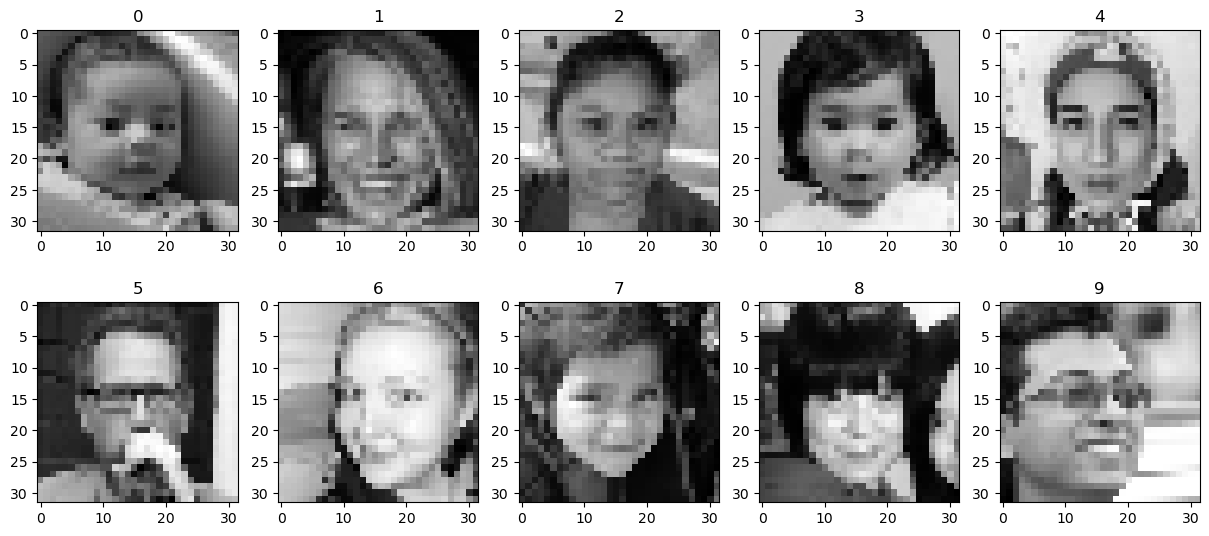

In [198]:
# test datagen
batch = next(datagen(train_folder, 10))

x_train_batch = batch[0]
y_train_batch = batch[1]

# Show x_train
for ii in range(x_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(x_train_batch[ii], cmap = 'gray'), plt.title(ii)

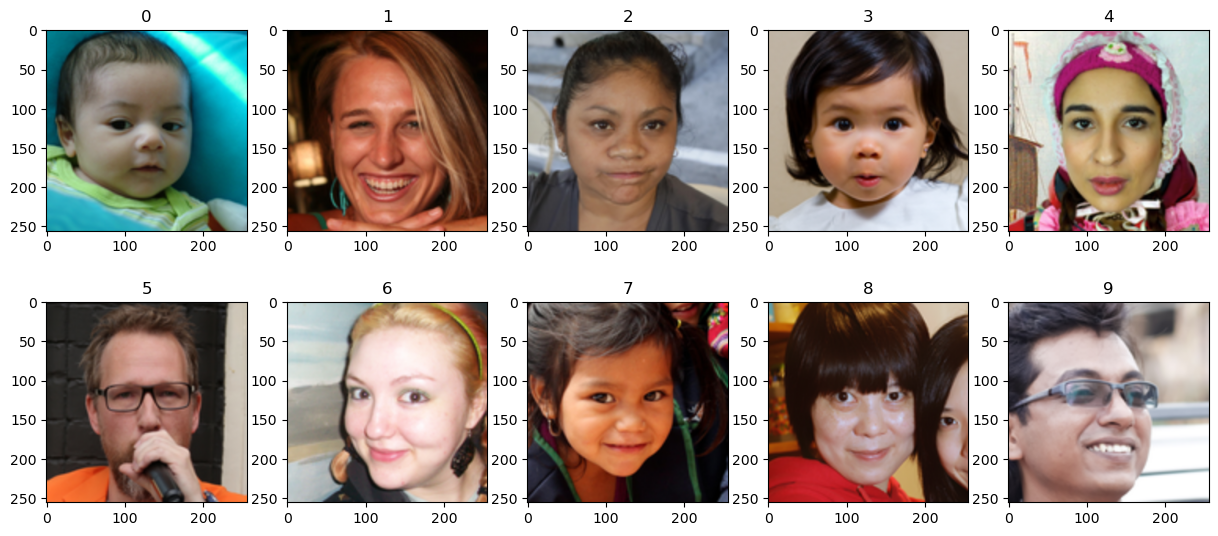

In [199]:
# Show y_train
for ii in range(y_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(y_train_batch[ii]), plt.title(ii)

In [200]:
def rdb_block(inputs, layers_count):
    # get number of input channels
    channels = inputs.get_shape()[-1]
    # initialize outputs list
    outputs = [inputs]
    
    # common Conv2D args
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

    # Make Residual Dense Block
    for _ in range(layers_count):
        concatenation = tf.concat(outputs, axis=-1)
        net = Conv2D(channels, 3, **conv_args)(concatenation)
        outputs.append(net)

    # Make final resulting net
    final_concatenation = tf.concat(outputs, axis=-1)
    final_net = Conv2D(channels, 1, **conv_args)(final_concatenation)

    # Add input net and final output net (RDB)
    final_net = Add()([final_net, inputs])

    return final_net

In [206]:
def psnr(orig, pred):
	# cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)
	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)
	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [205]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

scale_ratio = y_img_size / x_img_size
print('Scale ratio: ', scale_ratio)

inputs = Input(shape=(x_img_size, x_img_size, 1))
net = Conv2D(64, 5, **conv_args)(inputs)
net = Conv2D(64, 3, **conv_args)(net)
# Adding RDB Block
net = rdb_block(net, layers_count=7)
net = Conv2D(32, 3, **conv_args)(net)
# Another one RDB Block
net = rdb_block(net, layers_count=7)
# Pixel Shuffle magic here
net = Conv2D(y_img_channels * (scale_ratio ** 2), 3, **conv_args)(net)
outputs = tf.nn.depth_to_space(net, scale_ratio)

#net = Conv2D(128, 13, **conv_args)(inputs)
#net = MaxPooling2D(2)(net)
#net = Conv2D(64, 5, **conv_args)(inputs)
#net = Conv2D(64, 3, **conv_args)(net)
#net = Dropout(0.1)(net)
#net = Conv2D(32, 3, **conv_args)(net)
#net = Conv2D(3 * (scale_ratio ** 2), 3, **conv_args)(net)
#net = Dropout(0.2)(net)
#outputs = tf.nn.depth_to_space(net, scale_ratio)


model = Model(inputs, outputs)
model.summary()

Scale ratio:  8.0
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_96 (Conv2D)             (None, 32, 32, 64)   1664        ['input_19[0][0]']               
                                                                                                  
 conv2d_97 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_96[0][0]']              
                                                                                                  
 tf.identity_7 (TFOpLambda)     (None, 32, 32, 64)   0           ['conv2d_97[0][0]']              
                                                                         

In [207]:
# Train the network
epochs = 3
batch_size = 64
steps_per_epoch = train_set_len / batch_size + 1

print(steps_per_epoch)

src = datagen(train_folder, batch_size)

x_test, y_test = next(datagen(test_folder, test_set_len))

print(len(x_test))

#validation_data = (x_test), np.array(y_test))

model.compile(loss="mse", optimizer="adam", metrics=psnr)
#history = model.fit(src, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_data)
history = model.fit(src, epochs=epochs, validation_data=(x_test, y_test))

1021.0625
1000
Epoch 1/3
    366/Unknown - 1366s 4s/step - loss: 0.0187 - psnr: 17.8275

KeyboardInterrupt: 

1/1 [==============================] - 0s 82ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

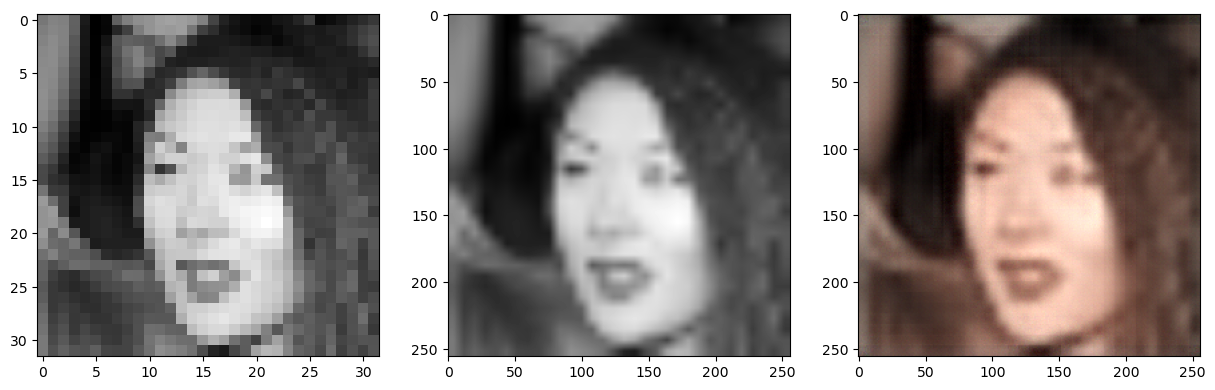

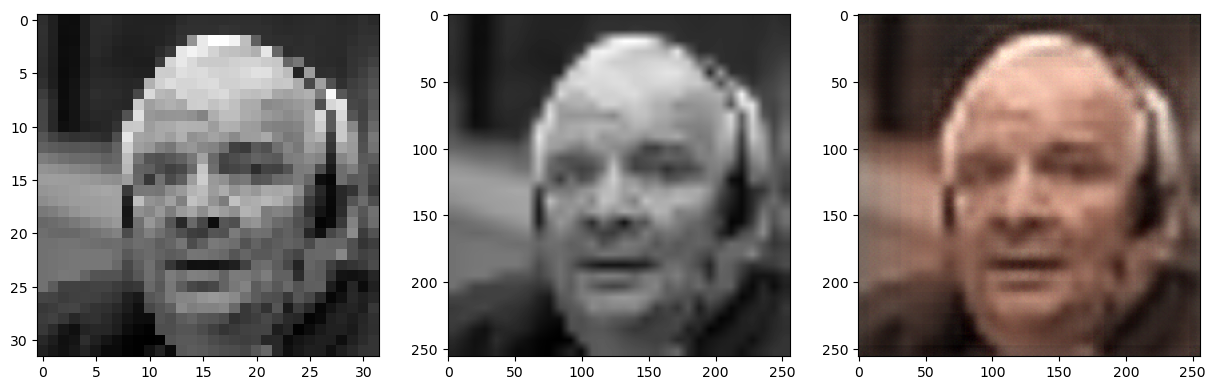

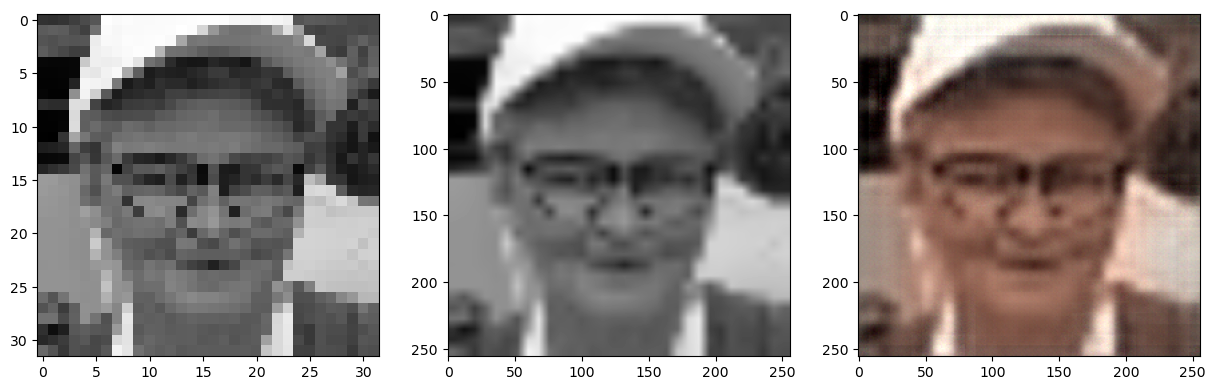

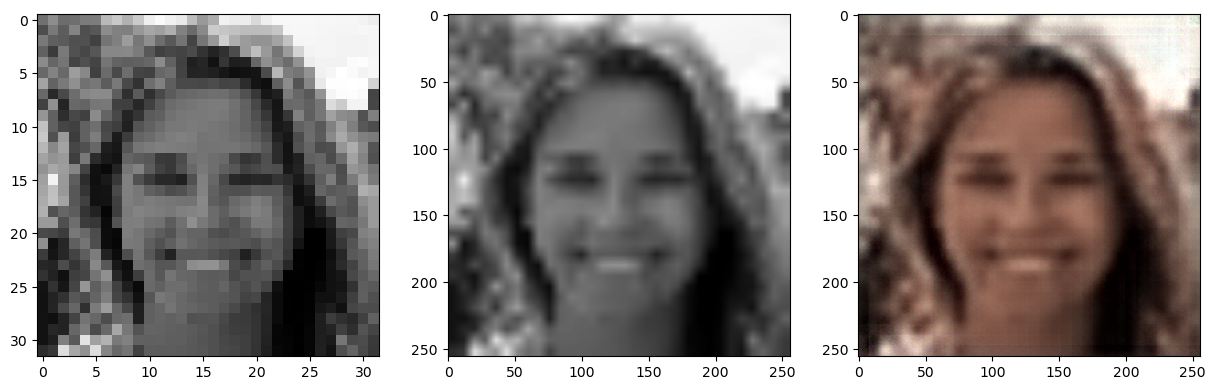

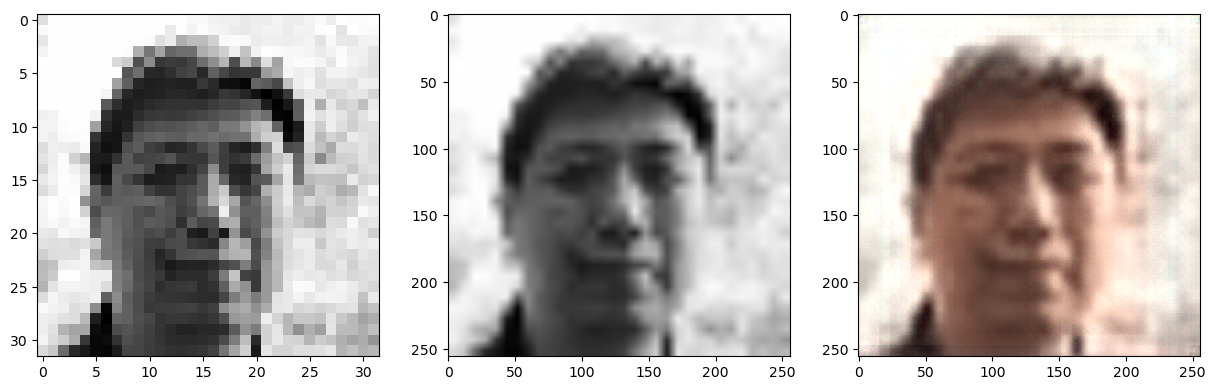

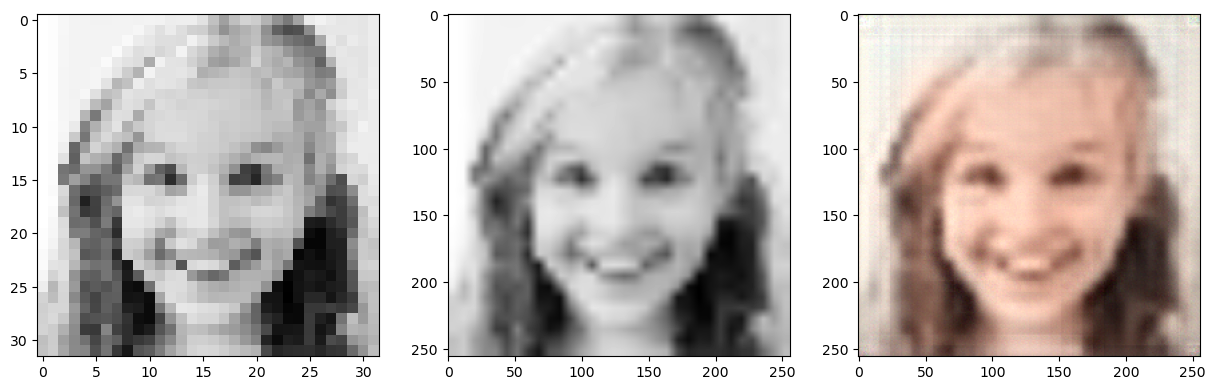

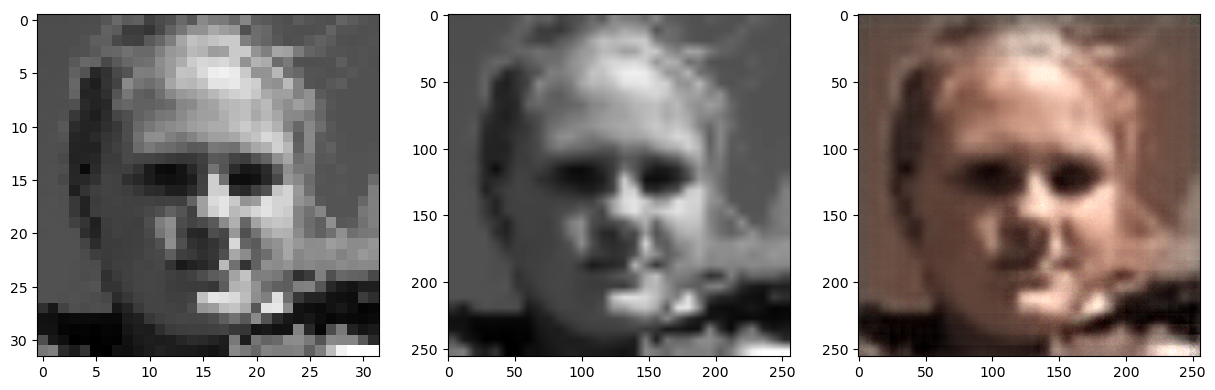

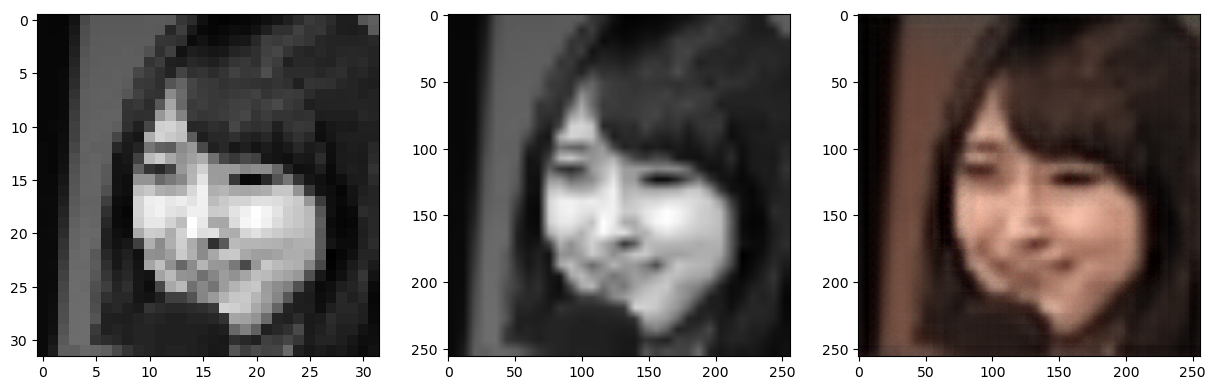

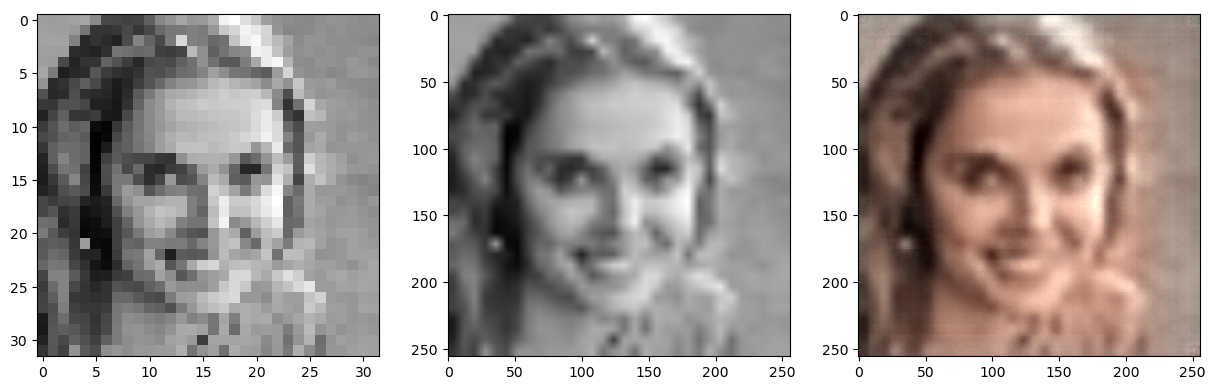

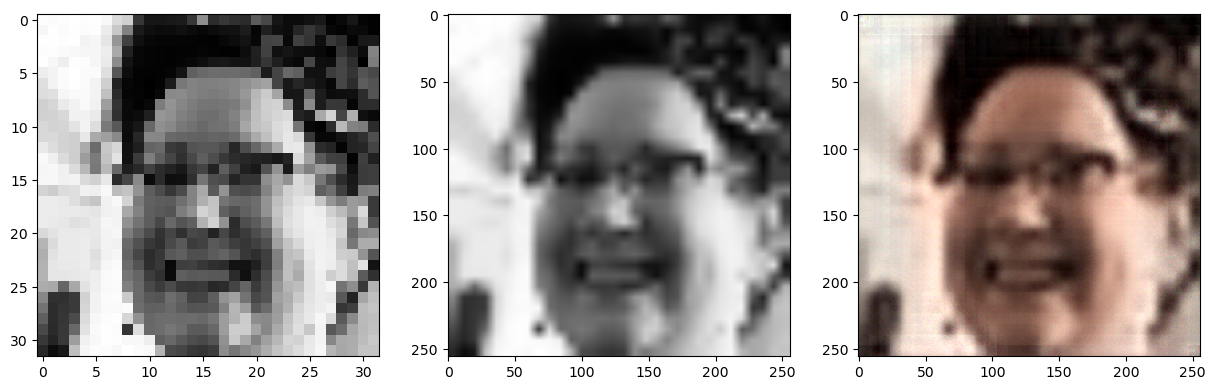

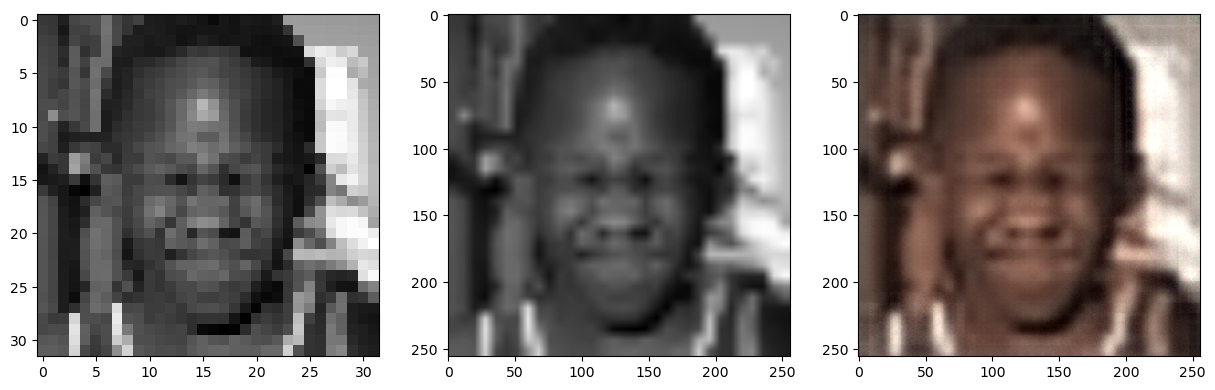

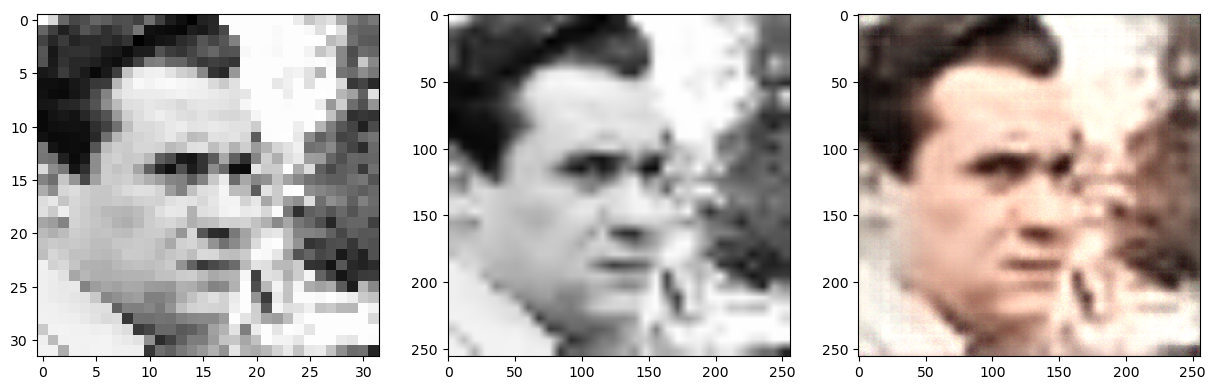

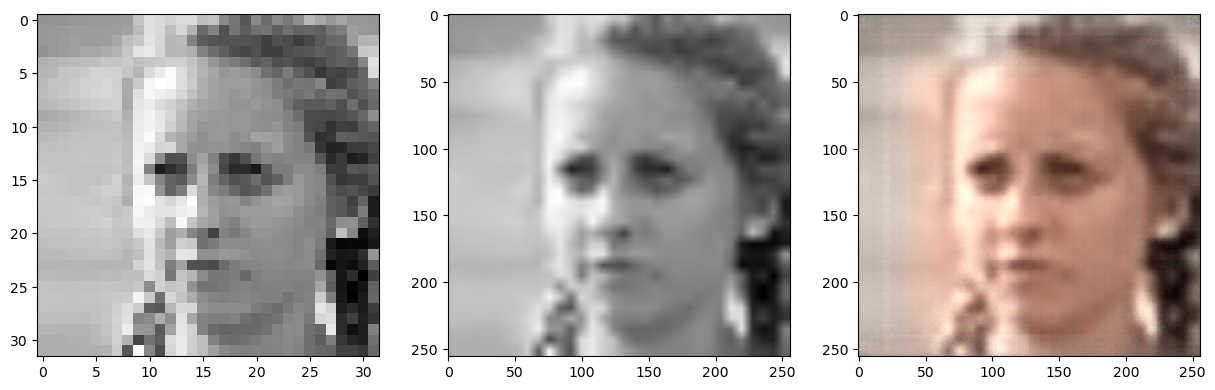

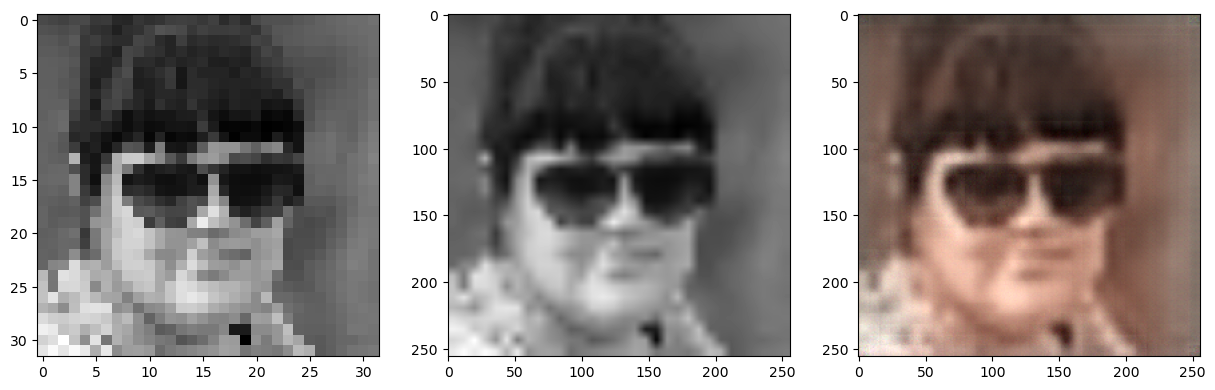

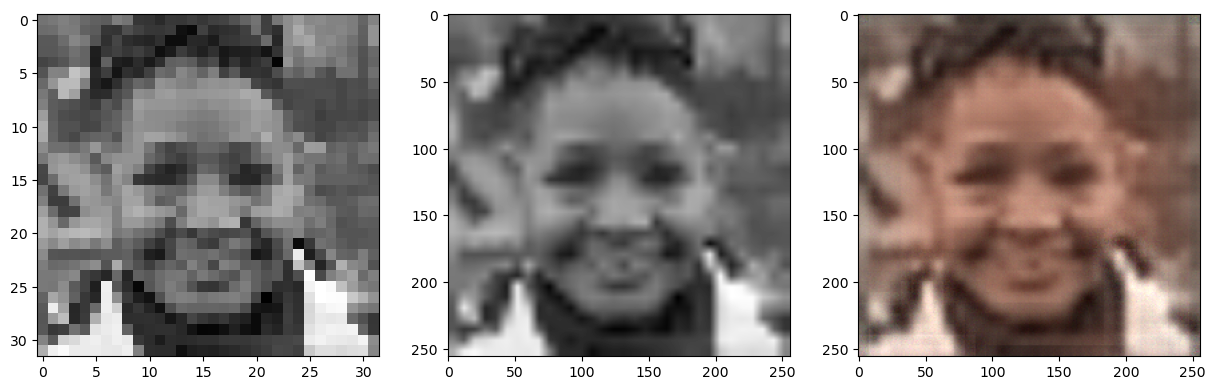

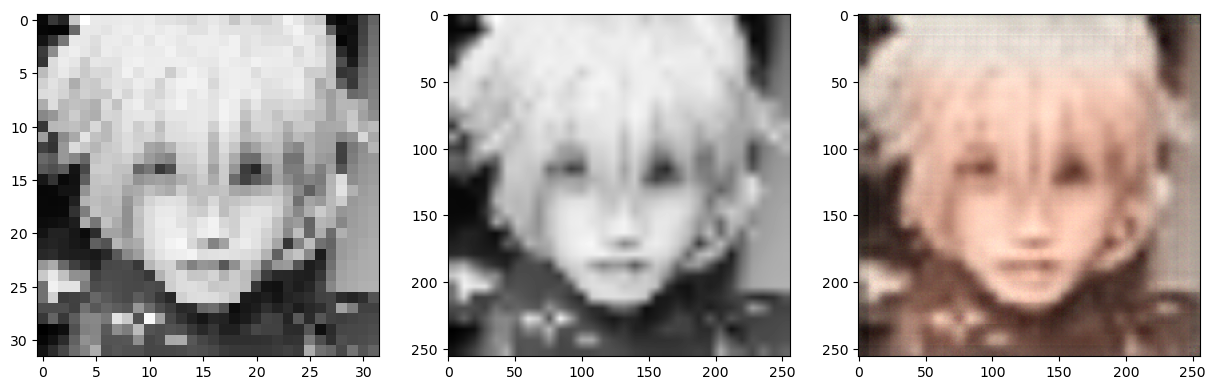

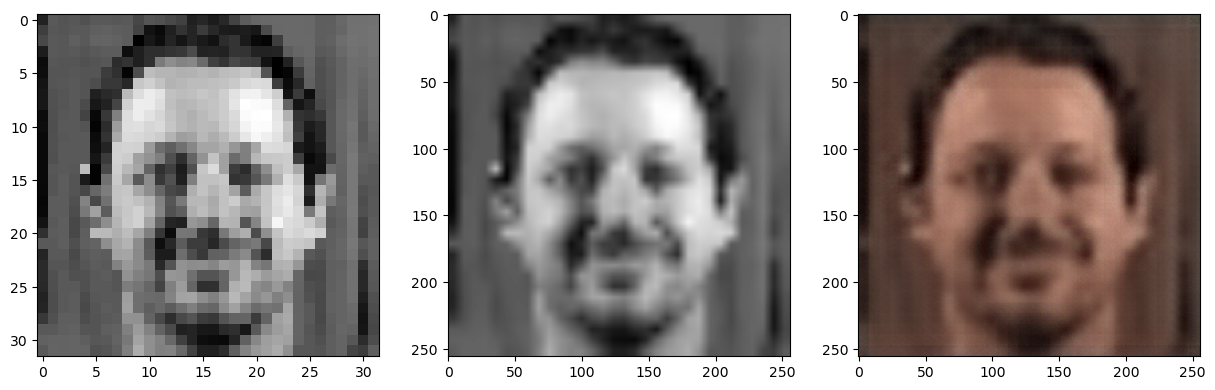

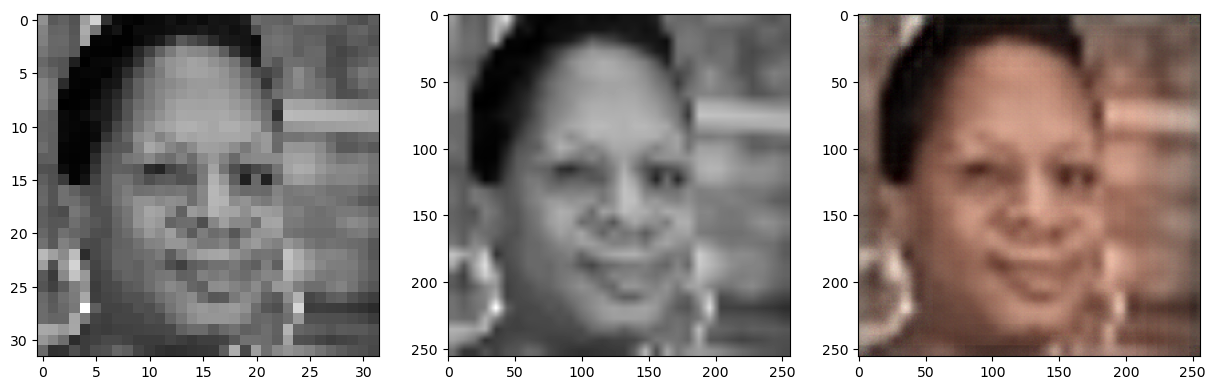

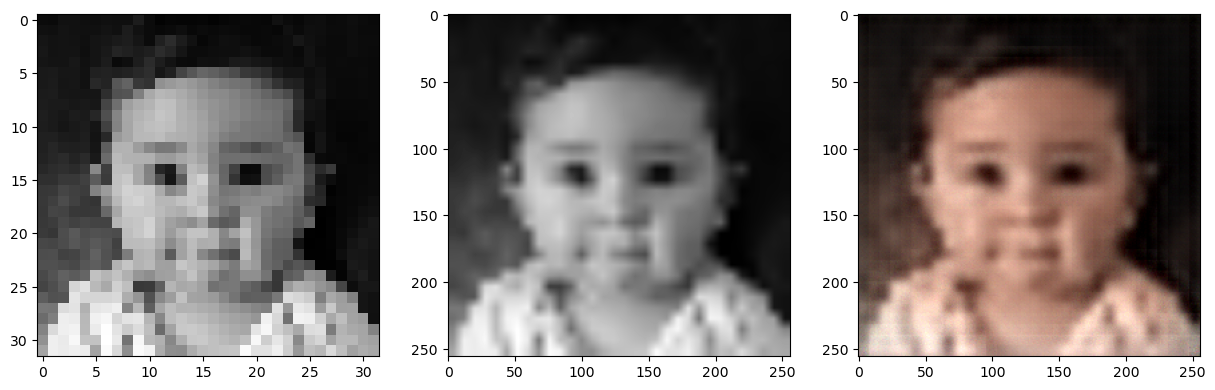

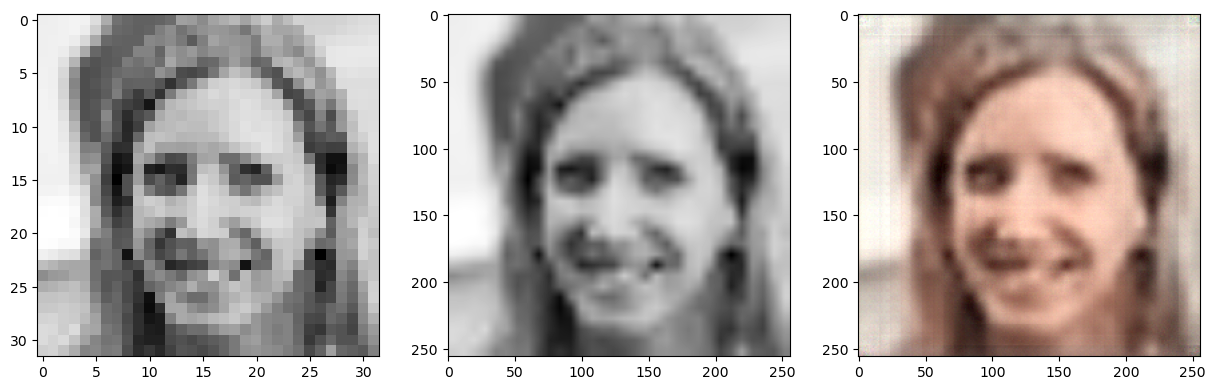

In [204]:
test_range = 20

batch = next(datagen(test_folder, test_range))

x_test = batch[0]

y_test = model.predict(x_test)

#img = np.array(y_test[9])

#plt.imshow(img)

#for ii in range(0, test_range-1):
#    plt.subplot(10, 2, 1), plt.imshow(x_test[ii], cmap='gray')
#    plt.subplot(10, 2, 2), plt.imshow(np.array(y_test[ii]))

for ii in range(test_range):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(x_test[ii], cmap='gray')
    axarr[1].imshow(cv2.resize(x_test[ii], (y_img_size, y_img_size), interpolation=cv2.INTER_LINEAR), cmap='gray')
    axarr[2].imshow(np.array(y_test[ii]))
